Задача: создать сверточную НС для распознавания музыкального инструмента по аудиодорожке, достигнуть приемлемой точности.\ Для этого необходимо:\
1. Используя соответствующий набор данных для обучения, преобразовать данные в пригодный для обучения НС вид\
2. Обучить сеть, достигнув результатов в обучении (возрастающая точность)

Исходный код и README: https://github.com/justvlike/collab_recognition

Привязка и загрузка содержимого IRMAS c GDrive\
IRMAS доступен для скачивания по ссылке https://zenodo.org/records/1290750#.WzCwSRyxXMU \
для обучения используется IRMAS-TrainingData.zip

In [ ]:
from google.colab import drive

# Привязка Google Drive
drive.mount('/content/drive')


Mounted at /content/drive


Проверка, подтянуты ли файлы. Если успешно - в составе вывода должен быть архив IRMAS-TrainingData.zip

In [ ]:
import os

# Вывод файлов Google Drive
os.listdir('/content/drive/My Drive/University/Maga')


['ADDITIONS 1st SEMESTER.gdoc',
 'MASTERS 1st SEMESTER.gdoc',
 'IRMAS-TrainingData.zip']

Разархивация архива, помещение подготовленных данных в соостветствующую директорию

In [ ]:
import zipfile

zip_file_path = '/content/drive/My Drive/University/Maga/IRMAS-TrainingData.zip'
extract_folder = '/content/irmas_dataset'

# Разархивация загруженного архива
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

# Вывод содержимого распакованного архива
os.listdir(extract_folder)


['IRMAS-TrainingData']

Подготовка зависимостей Python

In [ ]:
!pip show tensorflow


Name: tensorflow
Version: 2.17.1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.10/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tf_keras


In [ ]:
!pip install librosa matplotlib tensorflow numpy


Убедиться, что все распаковано успешно и иерархия папок соблюдена - важно при преобразовании wav аудио файлов в спектрограммы позже

In [ ]:
import os

# Указываем непосредственно внутрь распакованного архива
dataset_path = '/content/irmas_dataset/'
training_path = os.path.join(dataset_path, 'IRMAS-TrainingData')

# Выводим подкаталоги
os.listdir(training_path)


['cel',
 'pia',
 'voi',
 'flu',
 'cla',
 'org',
 'tru',
 'gel',
 'gac',
 'sax',
 'vio',
 'README.txt']

Функция преобразования аудио в спектрограммы для обучения

In [ ]:
import librosa
import numpy as np

def load_audio_and_convert_to_spectrogram(audio_file, n_mels=128):
    # Загружаем аудио через librosa
    y, sr = librosa.load(audio_file, sr=None)  # Load with original sampling rate
    # Создаем Mel-spectrogram
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
    # Переводим в log scale для лучшего представления
    log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)
    return log_spectrogram


Подготовка данных для обучения - преобразование аудио в спектрограммы для последующего обучения

In [ ]:
import glob

def prepare_training_data(training_path, n_mels=128):
    X = []  # Features (spectrograms)
    y = []  # Labels (instrument classes)

    # Маппим в соответствии с папками в архиве
    instrument_map = {
        'cel': 0, 'cla': 1, 'flu': 2, 'gac': 3, 'gel': 4,
        'org': 5, 'pia': 6, 'sax': 7, 'tru': 8, 'vio': 9, 'voi': 10
    }

    # Проход по всем подкаталогам и непосредственно преобразование
    for instrument, label in instrument_map.items():
        folder_path = os.path.join(training_path, instrument)
        for audio_file in glob.glob(os.path.join(folder_path, '*.wav')):
            spectrogram = load_audio_and_convert_to_spectrogram(audio_file, n_mels=n_mels)
            X.append(spectrogram)
            y.append(label)

    return np.array(X), np.array(y)

# Подготовка данных, вызов функции преобразования
X, y = prepare_training_data(training_path)
print(f"Data prepared: {X.shape}, Labels: {y.shape}")

Data prepared: (6705, 128, 259), Labels: (6705,)


Нормализация спектрограмм, преобразование датасетов для НС

In [ ]:
from sklearn.model_selection import train_test_split

# Нормализация спектрограмм к облатстям [0, 1]
X = X / np.max(X)

# Разделим данные (80% на обучение, 20% на проверку)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Добавляем параметр для дальнейшего использования сверточной НС
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]

print(f"Training data: {X_train.shape}, Validation data: {X_val.shape}")


Training data: (5364, 128, 259, 1), Validation data: (1341, 128, 259, 1)


Построение и тренировка НС с использованием подготовленных данных

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Модель сверточной НС
def build_model(input_shape, num_classes):
    model = models.Sequential([
        # Первый сверточный блок
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Второй сверточный блок
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Третий сверточный блок
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),

        # Дополнительные слои
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [ ]:
from tensorflow.keras.utils import to_categorical

# Преобразование y_train и y_val в более удобный формат.
y_train = to_categorical(y_train, num_classes=len(set(y)))
y_val = to_categorical(y_val, num_classes=len(set(y)))


In [ ]:
# Строим модель
input_shape = X_train.shape[1:]  # Размер спектрограмм
num_classes = len(set(y))  # Количество типов классов
model = build_model(input_shape, num_classes)
model.summary()

# Обучаем модель
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,  # Больше проходов - сильнее обучение
    batch_size=32
)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 128, 259, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128, 259, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 64, 129, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64, 129, 32)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 129, 64)         │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 129, 64)         │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 32, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32, 64, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 64, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 16, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16, 32, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 11)                  │           2,827 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,419 (505.54 KB)

 Trainable params: 128,971 (503.79 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 754s 4s/step - accuracy: 0.2066 - loss: 2.2685 - val_accuracy: 0.1193 - val_loss: 2.9341
Epoch 2/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 755s 4s/step - accuracy: 0.2839 - loss: 2.0398 - val_accuracy: 0.1506 - val_loss: 3.7466
Epoch 3/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 776s 4s/step - accuracy: 0.3483 - loss: 1.8786 - val_accuracy: 0.1849 - val_loss: 2.5960
Epoch 4/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 736s 4s/step - accuracy: 0.4191 - loss: 1.6926 - val_accuracy: 0.1842 - val_loss: 2.5380
Epoch 5/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 748s 4s/step - accuracy: 0.4927 - loss: 1.5033 - val_accuracy: 0.3177 - val_loss: 2.0202
Epoch 6/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 746s 4s/step - accuracy: 0.5239 - loss: 1.3812 - val_accuracy: 0.3363 - val_loss: 2.1130
Epoch 7/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 725s 4s/step - accuracy: 0.5541 - loss: 1.3026 - val_accuracy: 0.2483 - val_loss: 3.1002
Epoch 8/10
168/168 ━━━━━━━━━━━━━━━━━━━━ 746s 4s/step - accuracy: 0.5759 - loss: 1.2399 - val_accu

Построим графики точности и валидации

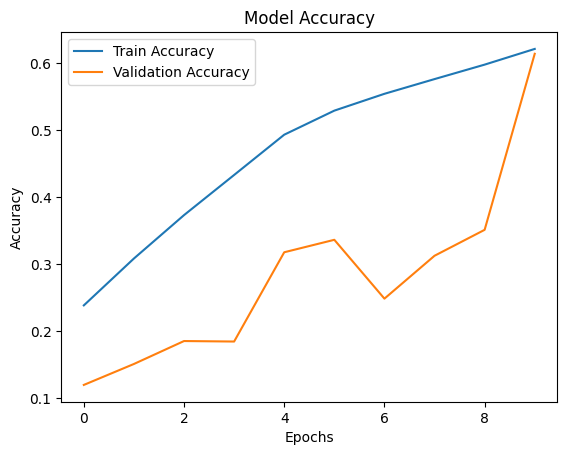

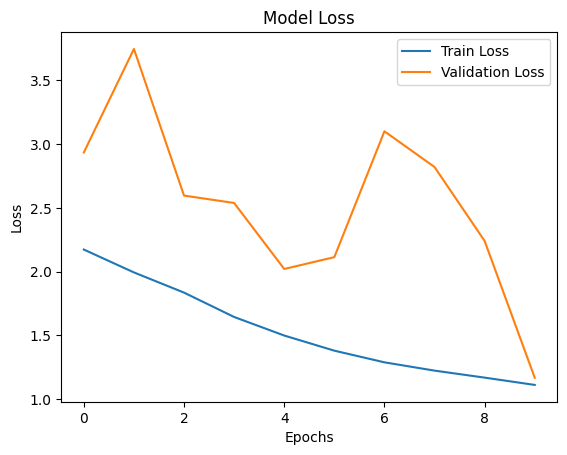

In [ ]:
import matplotlib.pyplot as plt

# График точности
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# График валидации
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


Можно проверить точность модели, а также сохранить ее образ

In [ ]:
# Точность
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

# Сохраняем модель
model.save('/content/instrument_classifier_model.h5')

42/42 ━━━━━━━━━━━━━━━━━━━━ 36s 861ms/step - accuracy: 0.6296 - loss: 1.1444


Validation Accuracy: 61.45%


Теперь можно проверить распознавание на реальном результате

Loaded audio shape: (132299,), Sample rate: 44100
Max amplitude: 0.45159912109375, Min amplitude: -0.488983154296875
Spectrogram shape: (128, 259)
Spectrogram max: 305.1554260253906, min: 6.765408788744764e-10


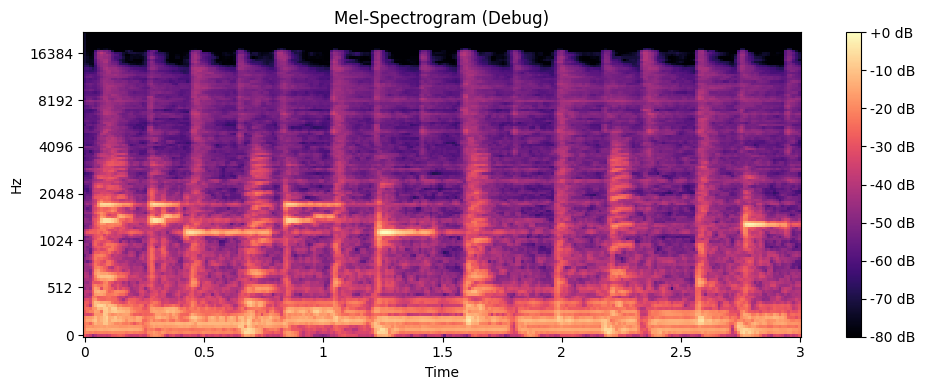

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
Predicted Instrument: org


In [30]:
import matplotlib.pyplot as plt
import librosa.display

# Функция отладки
def load_audio_and_convert_to_spectrogram_debug(audio_file, n_mels=128):
    import librosa
    import numpy as np

    try:
        # Загружаем аудио
        y, sr = librosa.load(audio_file, sr=None)
        print(f"Loaded audio shape: {y.shape}, Sample rate: {sr}")
        print(f"Max amplitude: {np.max(y)}, Min amplitude: {np.min(y)}")

        # Проверяем, если сигнал пустой
        if len(y) == 0 or np.max(y) == 0:
            raise ValueError("Audio file is silent or empty!")

        # Конвертируем в мел-спектрограмму
        spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        print(f"Spectrogram shape: {spectrogram.shape}")
        print(f"Spectrogram max: {np.max(spectrogram)}, min: {np.min(spectrogram)}")

        # Проверяем, содержит ли спектрограмма только нули
        if np.max(spectrogram) > 0:
            normalized_spectrogram = spectrogram / np.max(spectrogram)  # Нормализация
        else:
            raise ValueError("Spectrogram contains only zeros! Check the audio file or preprocessing steps.")

        # Визуализируем спектрограмму
        plt.figure(figsize=(10, 4))
        librosa.display.specshow(librosa.power_to_db(spectrogram, ref=np.max),
                                 sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title('Mel-Spectrogram (Debug)')
        plt.tight_layout()
        plt.show()

        return normalized_spectrogram
    except Exception as e:
        print(f"Error processing file {audio_file}: {e}")
        raise

# Последний блок
# Список доступных инструментов
instrument_map = {
    'cel': 0, 'cla': 1, 'flu': 2, 'gac': 3, 'gel': 4,
    'org': 5, 'pia': 6, 'sax': 7, 'tru': 8, 'vio': 9, 'voi': 10
}

# Инвертируем map
instrument_map_inv = {v: k for k, v in instrument_map.items()}

# Загружаем тестовый файл
test_audio_file = '/content/irmas_dataset/IRMAS-TrainingData/org/[org][jaz_blu]1045__2.wav'

# Используем функцию отладки
test_spectrogram = load_audio_and_convert_to_spectrogram_debug(test_audio_file)

# Добавляем ось для модели
test_spectrogram = test_spectrogram[np.newaxis, ..., np.newaxis]

# Делаем предсказание
predicted_label = model.predict(test_spectrogram).argmax()
print(f"Predicted Instrument: {instrument_map_inv[predicted_label]}")
